# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Camden Wehrle, Christine Berlingeri, Sarah Bae

**ID**: cw566, cnb53, ssb238

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\13158\Downloads`


In [46]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using Statistics

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Minimum value: 3.86 mg/L


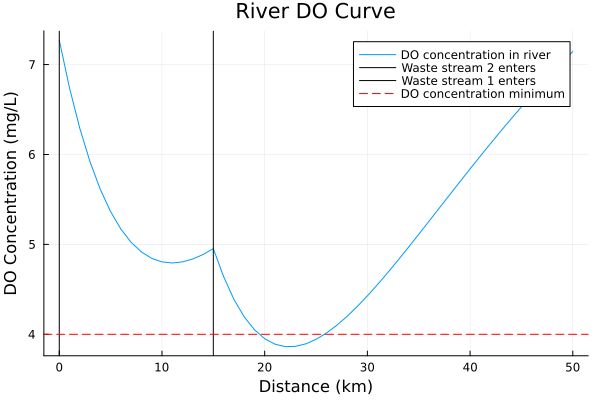

In [130]:
#function to evaluate new C, N, and B
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N) # C-->DO, B-->CBOD, N-->NBOD
end  

# inital river properties
Q_in = 100000 #m^3/day
C_in = 7.5 #mg/L
B_in = 5 #mg/L
N_in = 5 #mg/L

# waste stream 1 properies
Q_1 = 10000 #m^3/day
C_1 = 5 #mg/L
B_1 = 50 #mg/L #50
N_1 = 35 #mg/L #35

# waste stream 2 properties
Q_2 = 15000 #m^3/day
C_2 = 5 #mg/L
B_2 = 45 #mg/L
N_2 = 35 #mg/L

# decay values
ka = 0.55 #/day
kc = 0.35 #/day
kn = 0.25 #/day

Cs = 10 #mg/L 
U = 6 #km/day 

# distance in km 
x_1 = 0:15
x_2 = 1:35
x_3 = 0:50

#concentrations after waste stream 1 is mixed into river
WS1_C = ((Q_in * C_in) + (Q_1 * C_1)) / (Q_in + Q_1) #mg/L
WS1_B = ((Q_in * B_in) + (Q_1 * B_1)) / (Q_in + Q_1) #mg/L
WS1_N = ((Q_in * N_in) + (Q_1 * N_1)) / (Q_in + Q_1) #mg/L
# println(WS1_C," ", WS1_B," ", WS1_N)

# evaluating model after waste stream 1 from 0 to 15 km
do_new = (y -> do_simulate(y, WS1_C, WS1_B, WS1_N, ka, kc, kn, Cs, U)).(x_1)
C_new = [d[1] for d in do_new]
# println(C_new)

# concentrations in river at 15 km 
C_15 = do_new[16][1]
B_15 = do_new[16][2]
N_15 = do_new[16][3]
# println(C_15, " ", B_15, " ", N_15)
 
#concentrations after waste stream 2 is mixed into river
WS2_C = ((Q_2 * C_2) + ((Q_in + Q_1) * C_15)) / (Q_in + Q_1 + Q_2) #mg/L
WS2_B = ((Q_2 * B_2) + ((Q_in + Q_1) * B_15)) / (Q_in + Q_1 + Q_2) #mg/L
WS2_N = ((Q_2 * N_2) + ((Q_in + Q_1) * N_15)) / (Q_in + Q_1 + Q_2) #mg/L
# println(WS2_C," ", WS2_B," ", WS2_N)

# evaluating model after waste stream 2 from 15 to 50 km
do_out = (y -> do_simulate(y, WS2_C, WS2_B, WS2_N, ka, kc, kn, Cs, U)).(x_2)
C_out = [d[1] for d in do_out]
# println(C_out)

# append data from 0km to 15km and 15km to 50km
C_leave = append!(C_new, C_out)

# print minimum value of DO from 0km to 50km
println("Minimum value: ",round(minimum(C_leave), digits=2), " mg/L")

# plot data
plot(x_3, C_leave, xlabel = "Distance (km)", ylabel = "DO Concentration (mg/L)", title = "River DO Curve", label = "DO concentration in river", legend=:topright)
vline!([15], color=:black, label = "Waste stream 2 enters")
vline!([0], color=:black, label = "Waste stream 1 enters")
hline!([4], color=:red, linestyle=:dash, label = "DO concentration minimum")

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50 km downriver. What is the minimum value in mg/L?
    
The minimum value is 3.86 mg/L.

CBOD(B_1): 45.65, NBOD(N_1): 31.96
Total Organic Removal: 8.7%


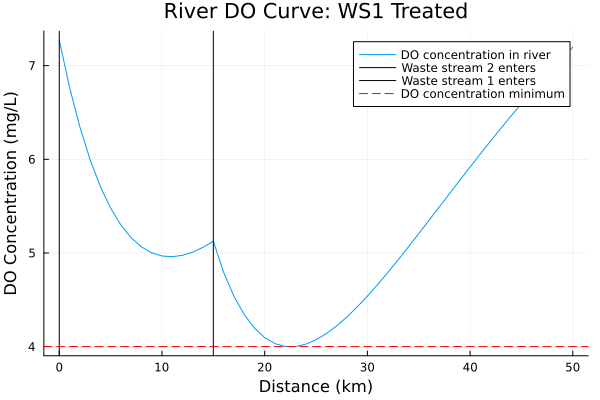

In [131]:
#function to evaluate new C, N, and B values
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end  

# Initial river properties
Q_in = 100000 #m^3/day
C_in = 7.5 #mg/L
B_in = 5 #mg/L
N_in = 5 #mg/L

# Waste stream 1 properties
Q_1 = 10000 #m^3/day
C_1 = 5 #mg/L
B_1 = 50 #mg/L
N_1 = 35 #mg/L

# Waste stream 2 properties
Q_2 = 15000 #m^3/day
C_2 = 5 #mg/L
B_2 = 45 #mg/L
N_2 = 35 #mg/L

# Decay values
ka = 0.55 #/day
kc = 0.35 #/day
kn = 0.25 #/day

Cs = 10 #mg/L 
U = 6 #km/day 

# Distance in km 
x_1 = 0:15
x_2 = 1:35
x_3 = 0:50

# Concentrations after waste stream 1 is mixed into river
WS1_C = ((Q_in * C_in) + (Q_1 * C_1)) / (Q_in + Q_1) #mg/L

# iterates through increasing % removals (1 being 0% and 0 being 100% removal) of WS1 conc.
for i in 1:-0.001:0
    WS1_B = ((Q_in * B_in) + (Q_1 * B_1 * i)) / (Q_in + Q_1) #mg/L
    WS1_N = ((Q_in * N_in) + (Q_1 * N_1 * i)) / (Q_in + Q_1) #mg/L
    
    # Evaluating model after waste stream 1 from 0 to 15 km
    do_new = (y -> do_simulate(y, WS1_C, WS1_B, WS1_N, ka, kc, kn, Cs, U)).(x_1)
    C_new = [d[1] for d in do_new]

    # Concentrations in river at 15 km 
    C_15 = do_new[16][1]
    B_15 = do_new[16][2]
    N_15 = do_new[16][3]
    
    # Concentrations after waste stream 2 is mixed into river
    WS2_C = ((Q_2 * C_2) + ((Q_in + Q_1) * C_15)) / (Q_in + Q_1 + Q_2) #mg/L
    WS2_B = ((Q_2 * B_2) + ((Q_in + Q_1) * B_15)) / (Q_in + Q_1 + Q_2) #mg/L
    WS2_N = ((Q_2 * N_2) + ((Q_in + Q_1) * N_15)) / (Q_in + Q_1 + Q_2) #mg/L

    # Evaluating model after waste stream 2 from 15 to 50 km
    do_out = (y -> do_simulate(y, WS2_C, WS2_B, WS2_N, ka, kc, kn, Cs, U)).(x_2)
    C_out = [d[1] for d in do_out]

    # Check if all C_out are greater than 4 mg/L, end loop when C_out is greater than 4 mg/L
    # Return the precent removal and the corresponding NBOD and CBOD values
    if all(c > 4 for c in C_out)
        println("CBOD(B_1): ", round(B_1 * i, digits=2), ", NBOD(N_1): ", round(N_1 * i, digits=2))
        total_removal = round((1 - i) * 100, digits=2)
        println("Total Organic Removal: ", total_removal, "%") 
        break
    end
end

# append data from 0km to 15km and 15km to 50km
C_leave = append!(C_new, C_out)

# plot data
plot(x_3, C_leave, xlabel = "Distance (km)", ylabel = "DO Concentration (mg/L)", title = "River DO Curve: WS1 Treated", label = "DO concentration in river", legend=:topright)
vline!([15], color=:black, label = "Waste stream 2 enters")
vline!([0], color=:black, label = "Waste stream 1 enters")
hline!([4], color=:red, linestyle=:dash, label = "DO concentration minimum")


-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?

    The minimum level of treatment for waste stream 1 that results in a DO concentration above 4 mg/L is 8.7% when waste stream 2 is untreated.

CBOD(B_2): 41.9, NBOD(N_2): 32.58
Total Organic Removal: 6.9%


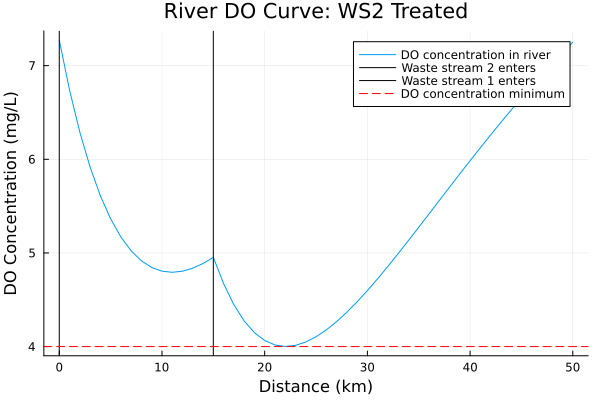

In [132]:
#function to evaluate new C, N, and B values
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N) 
end  

# inital river properties
Q_in = 100000 #m^3/day
C_in = 7.5 #mg/L
B_in = 5 #mg/L
N_in = 5 #mg/L

# waste stream 1 properies
Q_1 = 10000 #m^3/day
C_1 = 5 #mg/L
B_1 = 50 #mg/L
N_1 = 35 #mg/L

# waste stream 2 properties
Q_2 = 15000 #m^3/day
C_2 = 5 #mg/L
B_2 = 45 #mg/L
N_2 = 35 #mg/L

# decay values
ka = 0.55 #/day
kc = 0.35 #/day
kn = 0.25 #/day

Cs = 10 #mg/L 
U = 6 #km/day 

# distance in km 
x_1 = 0:15
x_2 = 1:35
x_3 = 0:50

# Concentrations after waste stream 1 is mixed into river
WS1_C = ((Q_in * C_in) + (Q_1 * C_1)) / (Q_in + Q_1) #mg/L
WS1_B = ((Q_in * B_in) + (Q_1 * B_1)) / (Q_in + Q_1) #mg/L
WS1_N = ((Q_in * N_in) + (Q_1 * N_1)) / (Q_in + Q_1) #mg/L

# Evaluating model after waste stream 1 from 0 to 15 km
do_new = (y -> do_simulate(y, WS1_C, WS1_B, WS1_N, ka, kc, kn, Cs, U)).(x_1)
C_new = [d[1] for d in do_new]

# Concentrations in river at 15 km
C_15 = do_new[16][1]
B_15 = do_new[16][2]
N_15 = do_new[16][3]

WS2_C = ((Q_2 * C_2) + ((Q_in + Q_1) * C_15)) / (Q_in + Q_1 + Q_2)

# iterates through increasing % removals (1 being 0% and 0 being 100% removal) of WS2 conc.
for i in 1:-0.001:0
    WS2_B = ((Q_2 * B_2*i) + ((Q_in + Q_1) * B_15)) / (Q_in + Q_1 + Q_2)
    WS2_N = ((Q_2 * N_2*i) + ((Q_in + Q_1) * N_15)) / (Q_in + Q_1 + Q_2)

    # Evaluating model after waste stream 2 from 15 to 50 km
    do_out = (y -> do_simulate(y, WS2_C, WS2_B, WS2_N, ka, kc, kn, Cs, U)).(x_2)
    C_out = [d[1] for d in do_out]

    # Check if all C_out are greater than 4 mg/L, end loop when C_out is greater than 4 mg/L
    # Return the precent removal and the corresponding NBOD and CBOD values
    if all(c > 4 for c in C_out)
        println("CBOD(B_2): ", round(B_2*i, digits=2), ", NBOD(N_2): ", round(N_2*i,digits=2))
        total_removal = round((1-i)*100, digits=2)
        println("Total Organic Removal: ", total_removal, "%")
        break  
    end
end

# append data from 0km to 15km and 15km to 50km
C_leave = append!(C_new, C_out)

# plot data
plot(x_3, C_leave, xlabel = "Distance (km)", ylabel = "DO Concentration (mg/L)", title = "River DO Curve: WS2 Treated", label = "DO concentration in river", legend=:topright)
vline!([15], color=:black, label = "Waste stream 2 enters")
vline!([0], color=:black, label = "Waste stream 1 enters")
hline!([4], color=:red, linestyle=:dash, label = "DO concentration minimum")

-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?

    To determine the minimum level of treatment, we decreased the values of CBOD and NBOD in either waste stream 1 or waste stream 2. We adjusted the values to be lower until the minimum DO concentration remained above 4mg/L. 
    
    The minimum level of treatment for waste stream 2 that results in a DO concentration above 4 mg/L is 6.9% when waste stream 1 is untreated. The minimum level of treatment for waste stream 1 that results in a DO concentration above 4 mg/L is 8.7% when waste stream 2 is untreated.

-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

    I would opt to treat both waste streams equally. Our work shows that treating waste stream 1 leads to an increase in the minimum DO concentration. It becomes a lot easier to prevent DO concentrations from going below the regulated limit if the first waste stream is treated. Several factors such as river volume and velocity could lead to fluctuations in DO concentration. If the minimum DO is too close to the regulated limit, fluctuations could occasionally dip below the regulated limit. However, if the minimum DO concentration is further above the regulated limit, such issues could be mitigated.
    
    Additionally, without any treatment of waste stream 1, the minimum DO would be low which could be damaging to aquatic life. The DO could recover at a higher concentration, which would allow for an easier rebound. 
    
    Other factors such as cost of treatment and ecosystem damage would be needed to make a conclusion. The decision to treat both waste streams equally could be more expensive than solely treating waste stream 2. If so, then it might be a better idea to only treat waste stream 2. Additionally, if there is a significantly negative effect to aquatic life if waste stream 1 is not treated, it could be a stronger reason to support the treatment of both waste streams. 

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [4]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

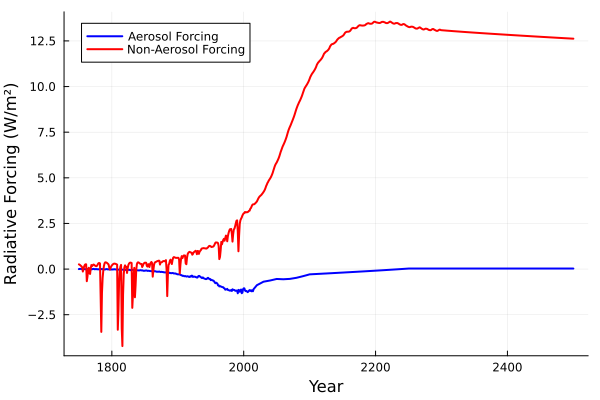

In [11]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

PROBLEM SOLUTION STARTS BELOW

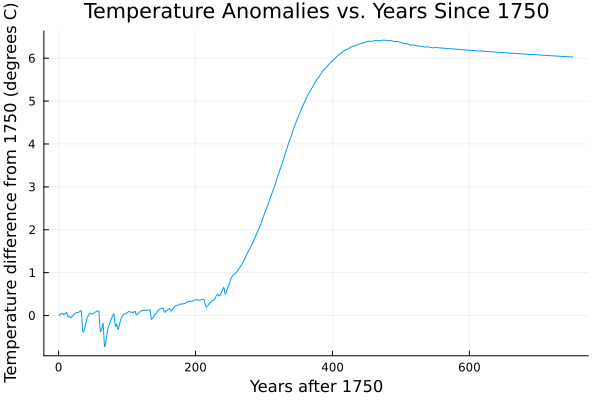

Expected temperature at 2100: 4.632496731623587


In [133]:
#Define basic model parameters
d = 86
c = 4184000
lambda = 2.1
alpha = .8
time_step = 31558152

#Compute the total forcings based off of given forcings from
#Data and the given alpha value
total_forcings = forcing_non_aerosol .+ alpha.*forcing_aerosol

#Iterate through all of the given years of Data
#Computing the new temperature value at each time step
length = size(total_forcings,1)
temp = zeros(length)
temp[1] = 0
for i in 2:length
    temp[i] = temp[i-1] + time_step*((total_forcings[i] - lambda*temp[i-1])/(c*d))
end

#Plot the temperature anomalies over the years
plotted = plot(temp, legend = false)
xlabel!("Years after 1750")
ylabel!("Temperature difference from 1750 (degrees C)")
title!("Temperature Anomalies vs. Years Since 1750")
temp_2100 = temp[350]
display(plotted)
println( "Expected temperature at 2100: ", temp_2100)

First for the problem we manipulated the given equations for the energy balance model to put it into Euler forward discretized form. The discretized version of the equations given above is: 

$T(t + \Delta t) = T(t) + \Delta t* (F - \lambda T(t))/cd$

Through this new form, we could find the temperature anomalies at each year by iterating through the given forcing data and computing the temperature change at each time step. It can be seen from the plot that the temperature increases by a little over 6 degrees Celsius at the maximum. 

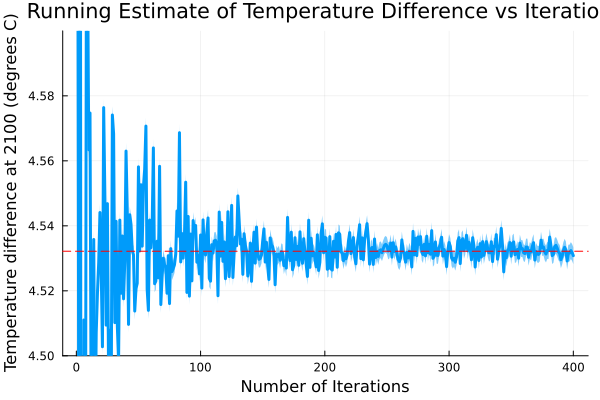

Mean estimated temperature at 2100: 4.532174893508309
The confidence interval is +/- 0.002592236136904101
The difference between the mean estimated temperature and the
expected temperature at 2100: 0.10032183811527862


In [134]:
#Ensure reproducible results by setting seed
Random.seed!(1)

#Define parameters, including inner loop count
#And the lognormal distribution
year_count = 2100-1750
lambda = LogNormal(log(2.1),log(2)/4)
iterations = 400
temp_2100_est = zeros(iterations)

#Change lambda at each outer loop iterations
#Each time looping through years 1750-2100
for p in 1:iterations
    lambda_new = rand(lambda)
    temp = zeros(year_count)
    temp[1] = 0
    for i in 2:year_count
        temp[i] = temp[i-1] + time_step*((total_forcings[i] - lambda_new*temp[i-1])/(c*d))
    end
    #Save a running estimate of temperature at 2100
    #To an array for each change in lambda
    temp_2100_est[p] = temp[year_count]
    temp_2100_est[p] = mean(temp_2100_est[1:p])
end

#Compute confidence interval and mean
#And plot results
standard_dev = std(temp_2100_est)
mean_temp = mean(temp_2100_est)
conf_interval = 1.96*(standard_dev/sqrt(iterations))
plotted = plot(temp_2100_est,  ribbon=conf_interval, legend = false,linewidth = 3, ylim = (4.5,4.6))
hline!(plotted, [mean_temp], color="red", linestyle=:dash)
xlabel!("Number of Iterations")
ylabel!("Temperature difference at 2100 (degrees C)")
title!("Running Estimate of Temperature Difference vs Iterations")
println("Mean estimated temperature at 2100: ", mean_temp)
println("The confidence interval is +/- ", conf_interval)
println("The difference between the mean estimated temperature and the
expected temperature at 2100: ", temp_2100 - mean_temp)
display(plotted)


In order to run the Monte Carlo simulation with different values of lambda, we placed the previously defined for loop inside another for loop. This meant that each time the outer for loop iterated, the value of lambda would change, and the temperature would be computed for each year from 1750 to 2100. We chose an arbitrary number of outer loop iterations, 1000, to start. After plotting the results once, it was seen that the simulation converged around 4.68 after around 300 iterations, so the simulation was re-reun with only 400 iterations to see the full convergence. Therefore, the sample set of 400 iterations seems sufficient as the temperature converges by that point. 

The temperature difference with the given lambda value of 2.1 was 4.632 at the year 2100. The values found from the lognormal distribution convergence for lambda show an average of 4.532 degrees Celsius. The 95% confidence interval for the Monte Carlo simulation was computed to be +/- .0026.This means the temperature with the given lambda value falls outside of the 95% confidence interval. Increasing the number of iterations would not help it fall into the interval as the interval would only get slightly smaller. We attempted to plot the confidence interval as a ribbon, but it can only faintly be seen, even when the plot is zoomed in. 

END OF PROBLEM SOLUTION

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.
